# 04 — Exploratory Data Analysis (EDA)

This notebook explores the  Cleaned labeled Netflix reviews dataset.  
It produces and saves visual assets for reporting and Streamlit:

- Rating distribution → `assets/rating_distribution.png`  
- Final sentiment distribution → `assets/final_sentiment_distribution.png`  
- Text vs Rating sentiment comparison → `assets/text_vs_rating_sentiment.png`  
- Agreement vs Conflict breakdown → `assets/sentiment_agreement_conflict.png`



## Load Cleaned Labeled dataset & imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import re
from collections import Counter
from wordcloud import WordCloud

In [3]:
# Path
CLEANED_OUTPUT_LABELED_PATH = Path("../data/netflix_reviews_Cleaned.csv")

# Load
df = pd.read_csv(CLEANED_OUTPUT_LABELED_PATH)
print(f"✅ Loaded Cleaned_labeled dataset with {len(df)} rows")

# Quick peek
df.head()

✅ Loaded Cleaned_labeled dataset with 41960 rows


,username,review,rating,date,country,source,clean_review,vader_score,sentiment,sentiment_rating,sentiment_combined,mismatch
0,Robert,"brainwashing children. don't deny it, the proo...",1,2025-10-08 00:57:12,NG,Play Store,brainwashing children dont deny proof pudding,-0.1190,negative,negative,negative,NaN
1,Abraham Bernabe,disgusting woke agenda. just cancel and uninst...,1,2025-10-08 00:35:03,NG,Play Store,disgusting woke agenda cancel uninstall garbage,-0.6597,negative,negative,negative,NaN
2,Kyle Martin,Please fix the pausing issue. I am trying to w...,2,2025-10-08 00:33:36,NG,Play Store,please fix pausing issue trying watch monday n...,-0.1779,negative,negative,negative,NaN
3,Jarrett,"Doesn't really have that much titles, heh lol",3,2025-10-08 00:30:51,NG,Play Store,doesnt really much titles heh lol,0.2350,positive,neutral,positive,NaN
4,Michael Raber,"gotta pay for the app, they raise the price wi...",1,2025-10-08 00:26:11,NG,Play Store,gotta pay app raise price warning work half time,-0.4215,negative,negative,negative,NaN


## Quick dataset summary


In [4]:
# Basic info and counts
print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())


Columns: ['username', 'review', 'rating', 'date', 'country', 'source', 'clean_review', 'vader_score', 'sentiment', 'sentiment_rating', 'sentiment_combined', 'mismatch']

Data types:
 username               object
review                 object
rating                  int64
date                   object
country                object
source                 object
clean_review           object
vader_score           float64
sentiment              object
sentiment_rating       object
sentiment_combined     object
mismatch               object
dtype: object

Missing values per column:
 username                  0
review                    0
rating                    0
date                   1960
country                   0
source                    0
clean_review            722
vader_score               0
sentiment                 0
sentiment_rating          0
sentiment_combined        0
mismatch              36785
dtype: int64


In [5]:
# Count per source
print("\nCounts by source:")
print(df['source'].value_counts())


Counts by source:
source
Play Store    40000
App Store      1960
Name: count, dtype: int64


In [27]:
# Sentiment by country
print("\nSentiment distribution by country:")
df.groupby('country')['sentiment_combined'].value_counts(normalize=True).unstack()



Sentiment distribution by country:


sentiment_combined,negative,neutral,positive
country,,,
CA,0.351573,0.166063,0.482364
GB,0.347950,0.163870,0.488179
NG,0.353765,0.167779,0.478456
US,0.356149,0.164633,0.479218


In [28]:
print("\nAverage VADER score by country:")
df.groupby('country')['vader_score'].median()



Average VADER score by country:


country
CA    0.2263
GB    0.2263
NG    0.2263
US    0.2023
Name: vader_score, dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41960 entries, 0 to 41959
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   username            41960 non-null  object 
 1   review              41960 non-null  object 
 2   rating              41960 non-null  int64  
 3   date                40000 non-null  object 
 4   country             41960 non-null  object 
 5   source              41960 non-null  object 
 6   clean_review        41238 non-null  object 
 7   vader_score         41960 non-null  float64
 8   sentiment           41960 non-null  object 
 9   sentiment_rating    41960 non-null  object 
 10  sentiment_combined  41960 non-null  object 
 11  mismatch            5175 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 3.8+ MB


In [7]:
df.describe()

,rating,vader_score
count,41960.000000,41960.000000
mean,2.976716,0.181137
std,1.845082,0.454996
min,1.000000,-0.964300
25%,1.000000,0.000000
50%,3.000000,0.226300
75%,5.000000,0.571900
max,5.000000,0.995100


In [8]:
df['rating'].value_counts()

rating
1    17512
5    16920
4     2672
2     2465
3     2391
Name: count, dtype: int64

In [9]:
# Mean and Median rating per Country and Source
grouped = df.groupby(['country', 'source'])['rating']
print(pd.DataFrame({
    'mean_rating': grouped.mean(),
    'median_rating': grouped.median()
}))

                    mean_rating  median_rating
country source                                
CA      App Store      3.359184            4.0
        Play Store     2.959700            3.0
GB      App Store      3.810204            5.0
        Play Store     2.959700            3.0
NG      App Store      3.148980            3.0
        Play Store     2.959700            3.0
US      App Store      2.977551            3.0
        Play Store     2.959700            3.0


In [10]:
import os

# Ensure assets folder exists
os.makedirs("assets", exist_ok=True)
print("📁 'assets' folder verified/created.")


📁 'assets' folder verified/created.


## Rating Distribution


Rating distribution:


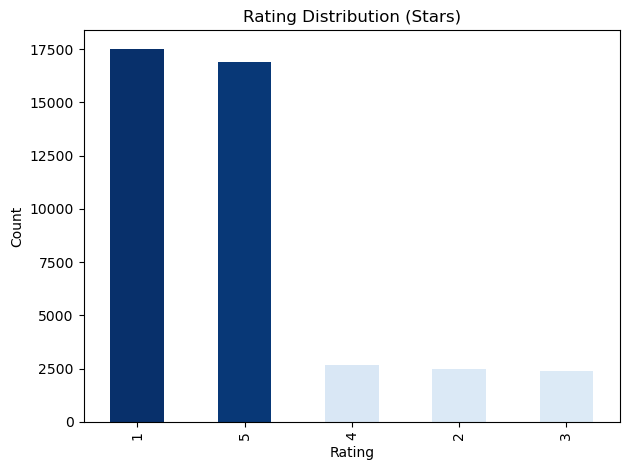

In [11]:
print("\nRating distribution:")
# Count ratings and sort descending
rating_counts = df['rating'].value_counts().sort_values(ascending=False)

# Generate colors based on counts (deeper color for higher count)
colors = plt.cm.Blues(rating_counts / rating_counts.max())

# Plot
rating_counts.plot(kind='bar', color=colors, title='Rating Distribution (Stars)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig("../assets/rating_distribution.png")  # Save to ROOT assets/
plt.show()


## Sentiment Combined Distribution


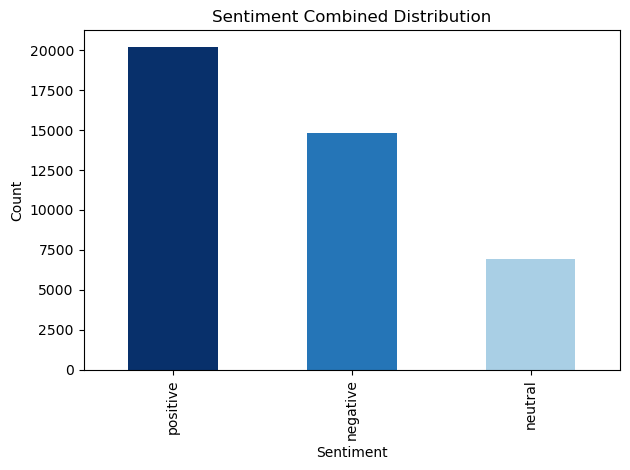

,pct
sentiment_combined,
positive,48.21
negative,35.24
neutral,16.56


In [13]:
# Count sentiments
sentiment_counts = df['sentiment_combined'].value_counts()

# Generate colors: deeper color for higher count
colors = plt.cm.Blues(sentiment_counts / sentiment_counts.max())

# Plot
sentiment_counts.plot(kind='bar', color=colors, title='Sentiment Combined Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig("../assets/sentiment_combined_distribution.png")
plt.show()

# Show percentages
(final_pct := (df['sentiment_combined'].value_counts(normalize=True) * 100).round(2)).to_frame(name='pct')

## Vader vs Rating vs Combined Sentiment Comparison


Cross-tab (counts):
 sentiment_rating  negative  neutral  positive
sentiment                                    
negative              8629      580       659
neutral               5576      517      3429
positive              5772     1294     15504

Cross-tab (% by text sentiment rows):
 sentiment_rating  negative  neutral  positive
sentiment                                    
negative             87.44     5.88      6.68
neutral              58.56     5.43     36.01
positive             25.57     5.73     68.69


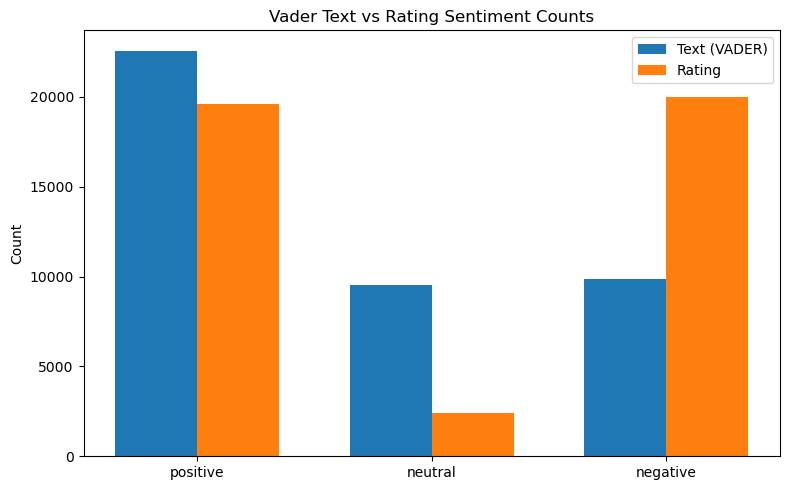

In [14]:
# Cross-tab between vader text label and rating label
ct_text_rating = pd.crosstab(df['sentiment'], df['sentiment_rating'], normalize='index') * 100
ct_text_rating_counts = pd.crosstab(df['sentiment'], df['sentiment_rating'])

print("Cross-tab (counts):\n", ct_text_rating_counts)
print("\nCross-tab (% by text sentiment rows):\n", ct_text_rating.round(2))

# Grouped bar chart: Vader text vs Rating label
labels = ['positive', 'neutral', 'negative']
x = np.arange(len(labels))
width = 0.35

text_counts = [df[df['sentiment']==lab].shape[0] for lab in labels]
rating_counts = [df[df['sentiment_rating']==lab].shape[0] for lab in labels]

plt.figure(figsize=(8,5))
plt.bar(x - width/2, text_counts, width, label='Text (VADER)')
plt.bar(x + width/2, rating_counts, width, label='Rating')
plt.xticks(x, labels)
plt.ylabel("Count")
plt.title("Vader Text vs Rating Sentiment Counts")
plt.legend()
plt.tight_layout()
plt.savefig("../assets/vader_text_sentiment_vs_rating_sentiment.png")
plt.show()

Cross-tab (counts):
 sentiment_combined  negative  neutral  positive
sentiment                                      
negative                9209      659         0
neutral                 5576      517      3429
positive                   0     5772     16798

Cross-tab (% by text sentiment rows):
 sentiment_combined  negative  neutral  positive
sentiment                                      
negative               93.32     6.68      0.00
neutral                58.56     5.43     36.01
positive                0.00    25.57     74.43


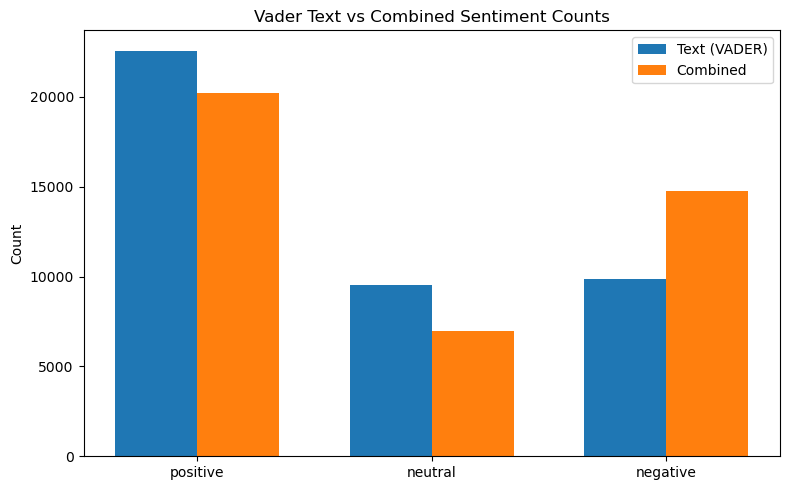

In [15]:
 
# Cross-tab vader text sentiment vs combined sentiment
ct_text_combined = pd.crosstab(df['sentiment'], df['sentiment_combined'], normalize='index') * 100
ct_text_combined_counts = pd.crosstab(df['sentiment'], df['sentiment_combined'])

print("Cross-tab (counts):\n", ct_text_combined_counts)
print("\nCross-tab (% by text sentiment rows):\n", ct_text_combined.round(2))

# Grouped bar chart: Vader text sentiment vs Combined sentiment
combined_counts = [df[df['sentiment_combined']==lab].shape[0] for lab in labels]

plt.figure(figsize=(8,5))
plt.bar(x - width/2, text_counts, width, label='Text (VADER)')
plt.bar(x + width/2, combined_counts, width, label='Combined')
plt.xticks(x, labels)
plt.ylabel("Count")
plt.title("Vader Text vs Combined Sentiment Counts")
plt.legend()
plt.tight_layout()
plt.savefig("../assets/vader_text_sentiment_vs_combined_sentiment.png")
plt.show()

## Agreement vs Conflict Breakdown (Vader Text vs Rating vs combined sentiment) — how often they agree



Agreement:  24650 of 41960 (58.75%)

Disagreement breakdown (counts):
 sentiment_rating  negative  neutral  positive
sentiment                                    
negative                 0      580       659
neutral               5576        0      3429
positive              5772     1294         0


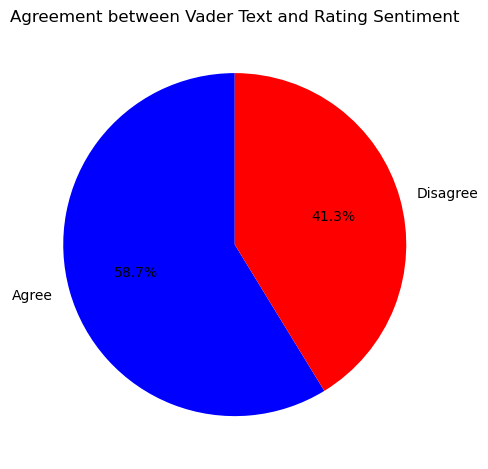

In [21]:
# Agreement between Vader text and Rating sentiment

df['text_equals_rating'] = df['sentiment'] == df['sentiment_rating']
agreement_count = df['text_equals_rating'].sum()
total = len(df)
agreement_pct = round(agreement_count / total * 100, 2)

# Cases where they disagree
disagree_df = df[df['text_equals_rating'] == False]

# Breakdown of disagreement types
disagree_breakdown = pd.crosstab(disagree_df['sentiment'], disagree_df['sentiment_rating'])

print("\nAgreement: ", agreement_count, "of", total, f"({agreement_pct}%)")
print("\nDisagreement breakdown (counts):\n", disagree_breakdown)

# Pie chart for agreement vs disagreement
plt.figure(figsize=(5,5))
plt.pie(
    [agreement_count, total - agreement_count],
    labels=['Agree', 'Disagree'],
    autopct="%1.1f%%",
    colors=['Blue', 'Red'],
    startangle=90
)
plt.title("Agreement between Vader Text and Rating Sentiment")
plt.tight_layout()
plt.savefig("../assets/vader_sentiment_text_vs_rating_sentiment_agreement.png")
plt.show()


Agreement:  26524 of 41960 (63.21%)

Disagreement breakdown (counts):
 sentiment_combined  negative  neutral  positive
sentiment                                      
negative                   0      659         0
neutral                 5576        0      3429
positive                   0     5772         0


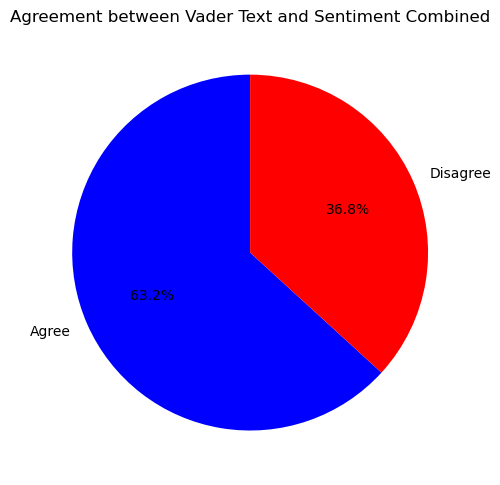

In [22]:
# Agreement between Vader text and Combined sentiment

df['text_equals_rating'] = df['sentiment'] == df['sentiment_combined']
agreement_count = df['text_equals_rating'].sum()
total = len(df)
agreement_pct = round(agreement_count / total * 100, 2)

# Cases where they disagree
disagree_df = df[df['text_equals_rating'] == False]

# Breakdown of disagreement types
disagree_breakdown = pd.crosstab(disagree_df['sentiment'], disagree_df['sentiment_combined'])

print("\nAgreement: ", agreement_count, "of", total, f"({agreement_pct}%)")
print("\nDisagreement breakdown (counts):\n", disagree_breakdown)

# Pie chart for agreement vs disagreement
plt.figure(figsize=(5,5))
plt.pie(
    [agreement_count, total - agreement_count],
    labels=['Agree', 'Disagree'],
    autopct="%1.1f%%",
    colors=['Blue', 'Red'],
    startangle=90
)
plt.title("Agreement between Vader Text and Sentiment Combined")
plt.tight_layout()
plt.savefig("../assets/vader_sentiment_text_vs_combined_sentiment_agreement.png")
plt.show()


Agreement:  33655 of 41960 (80.21%)

Disagreement breakdown (counts):
 sentiment_combined  negative  neutral  positive
sentiment_rating                               
negative                   0     5772         0
neutral                  580        0      1294
positive                   0      659         0


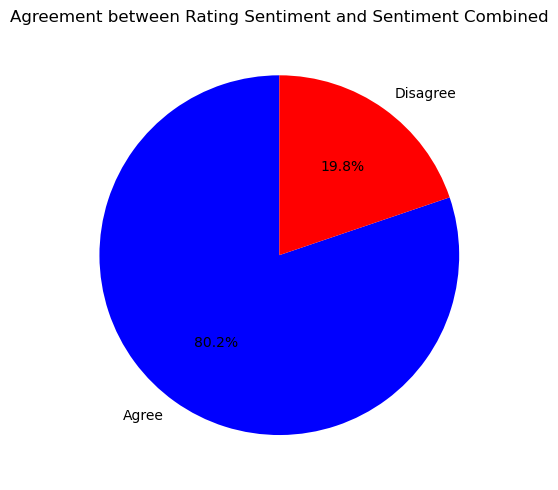

In [23]:
# Agreement between Rating sentiment and Combined sentiment

df['text_equals_rating'] = df['sentiment_rating'] == df['sentiment_combined']
agreement_count = df['text_equals_rating'].sum()
total = len(df)
agreement_pct = round(agreement_count / total * 100, 2)

# Cases where they disagree
disagree_df = df[df['text_equals_rating'] == False]

# Breakdown of disagreement types
disagree_breakdown = pd.crosstab(disagree_df['sentiment_rating'], disagree_df['sentiment_combined'])

print("\nAgreement: ", agreement_count, "of", total, f"({agreement_pct}%)")
print("\nDisagreement breakdown (counts):\n", disagree_breakdown)

# Pie chart for agreement vs disagreement
plt.figure(figsize=(5,5))
plt.pie(
    [agreement_count, total - agreement_count],
    labels=['Agree', 'Disagree'],
    autopct="%1.1f%%",
    colors=['Blue', 'Red'],
    startangle=90
)
plt.title("Agreement between Rating Sentiment and Sentiment Combined")
plt.tight_layout()
plt.savefig("../assets/sentiment_rating_vs_combined_sentiment_agreement.png")
plt.show()

In [26]:
# 3-way disagreement: Text, Rating, Combined
disagree_3way_df = df[
    ~(
        (df['sentiment'] == df['sentiment_rating']) &
        (df['sentiment'] == df['sentiment_combined'])
    )
]

# Sample up to 10 rows for review
sample_disagreements_3way = disagree_3way_df[[
    'clean_review',
    'rating',
    'vader_score',
    'sentiment',
    'sentiment_rating',
    'sentiment_combined'
]].sample(min(10, len(disagree_3way_df)), random_state=42)

sample_disagreements_3way


,clean_review,rating,vader_score,sentiment,sentiment_rating,sentiment_combined
396,full hd,1,0.0000,neutral,negative,negative
21595,sudah bayar tapi di tangguhkan suruh bayar lagi,1,0.0000,neutral,negative,negative
34163,fist check,2,0.0000,neutral,negative,negative
5282,watched movies always show pixelated,1,0.0000,neutral,negative,negative
33048,even tho good fast internet netflix shows does...,1,0.6319,positive,negative,neutral
25641,fav series movie netflix par nahi rahi leaving...,3,0.4588,positive,neutral,positive
1900,series,5,0.0000,neutral,positive,positive
39809,cant browser continue signing,5,0.0000,neutral,positive,positive
19005,plz plz fix problem movie lagging plz fix,3,-0.4404,negative,neutral,negative
35554,bloatware,1,0.0000,neutral,negative,negative


## Sentiment Over Time

In [29]:
# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print("Rows failed to convert:", df['date'].isna().sum())

Rows failed to convert: 1960


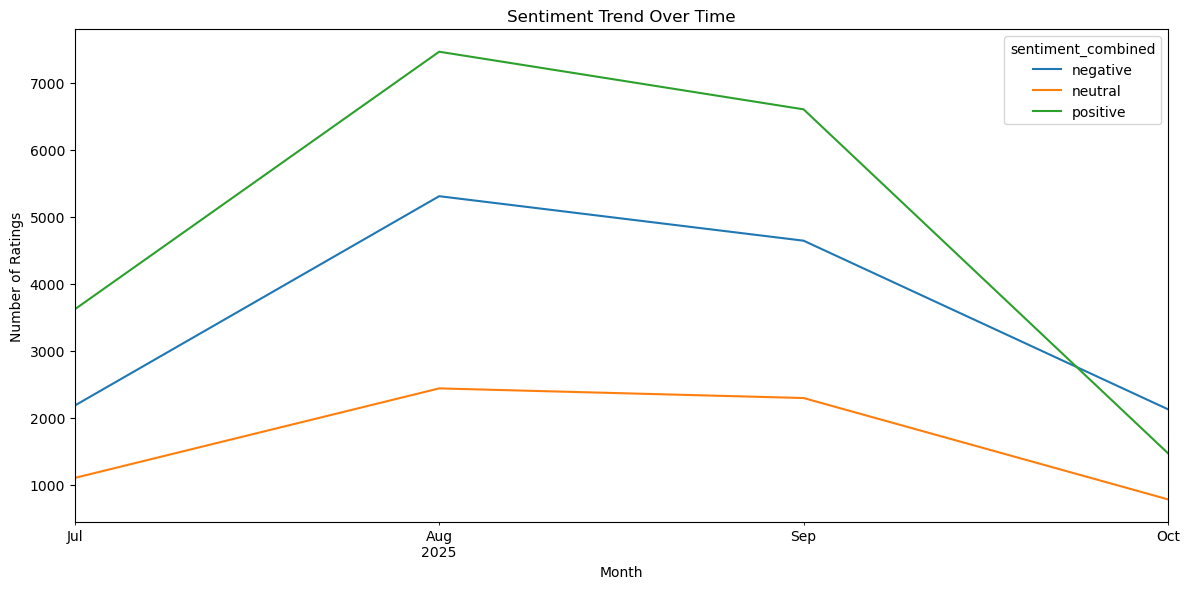

In [32]:
# Sentiment_combined trend over time
df.set_index('date').groupby('sentiment_combined')['rating'].resample('ME').count().unstack(0).plot(title='Sentiment Trend Over Time', figsize=(12,6))
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.tight_layout()
plt.savefig("../assets/sentiment_trend_over_time.png")
plt.show()

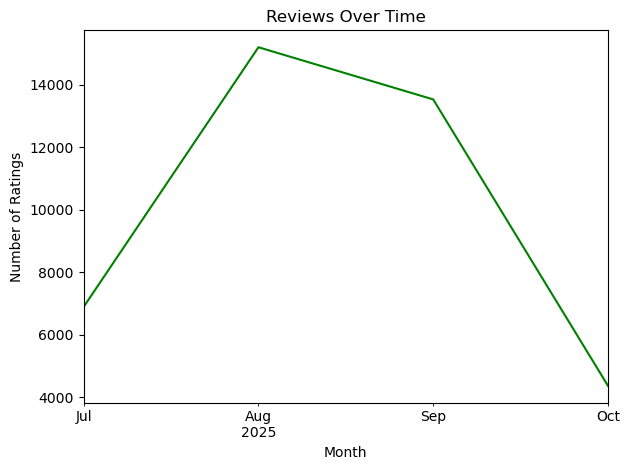

In [33]:
# rating trend over time
df.set_index('date')['rating'].resample('ME').count().plot(
    title='Reviews Over Time', color='green'
)
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.tight_layout()
plt.savefig("../assets/reviews_over_time.png")
plt.show()

## WordCloud

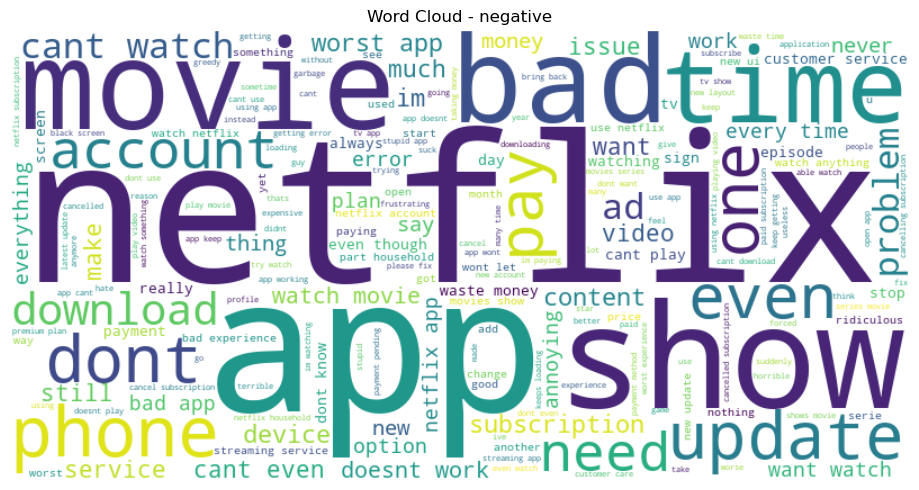

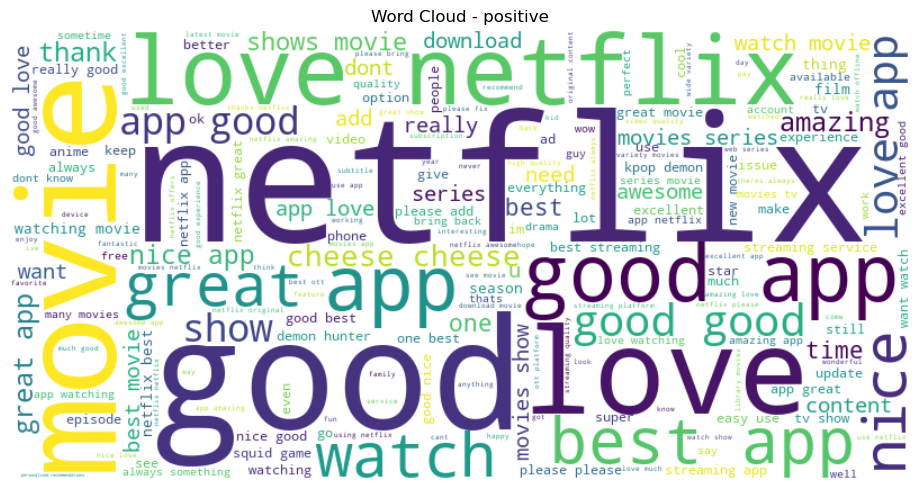

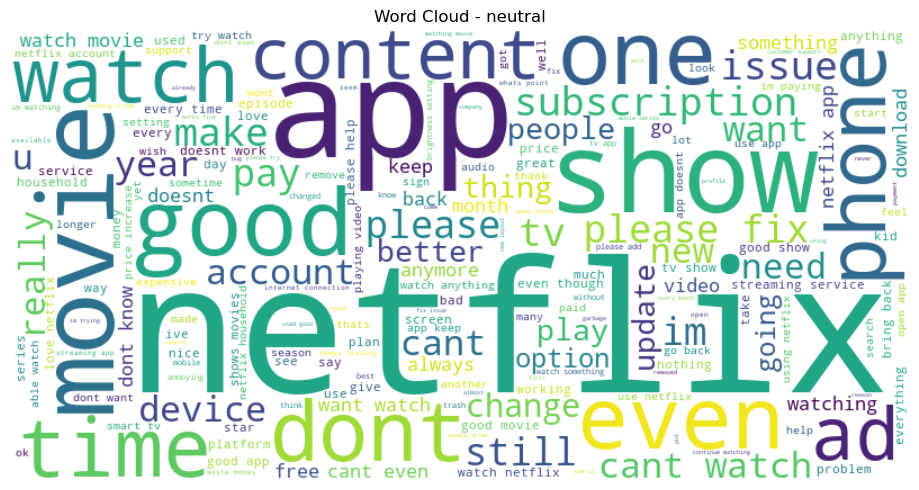

In [35]:

# Word cloud by sentiment
for sentiment in df['sentiment_combined'].unique():
    text = ' '.join(df[df['sentiment_combined']==sentiment]['clean_review'].dropna())
    if text.strip():
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud - {sentiment}')
        plt.tight_layout()
        plt.savefig("../assets/wordcloud.png")
        plt.show()

### ✅ EDA Complete — Next Steps

➡️ Next Notebook: **04_exploratory_data_analysis.ipynb**
